0.25


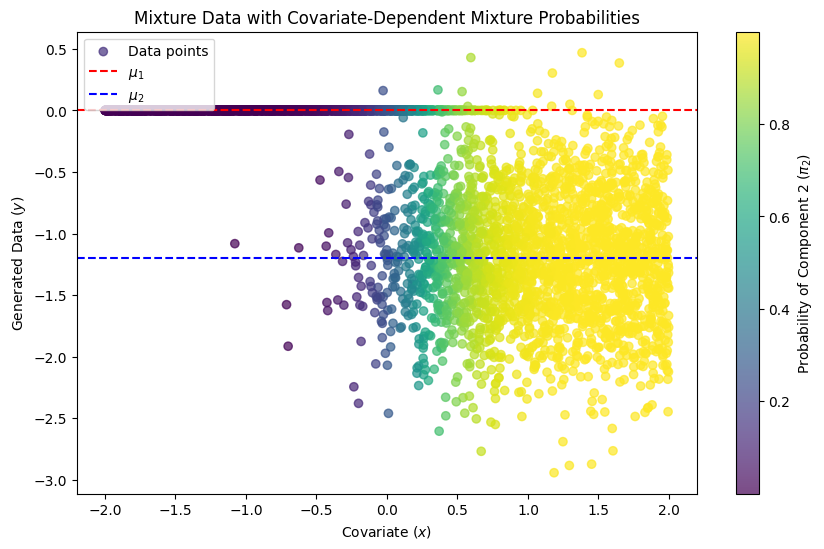

In [49]:
import numpy as np
import matplotlib.pyplot as plt
 
n_samples = 5000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = -1.20,  0.5


print(sigma_2_sq   **2 )

sebetahat= np.random.uniform( 0.1, 0.5, n_samples)
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = 0
        betahat[i]= y[i]+ np.random.normal(0, sebetahat[i] )
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   )
        betahat[i]= y[i]+ np.random.normal(0,   sebetahat[i] )


# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


In [50]:
np.var(y)

np.float64(0.47941648693639244)

In [51]:
np.var(betahat)

np.float64(0.5888747860051166)

In [52]:
0.2**2+0.5**2

0.29000000000000004

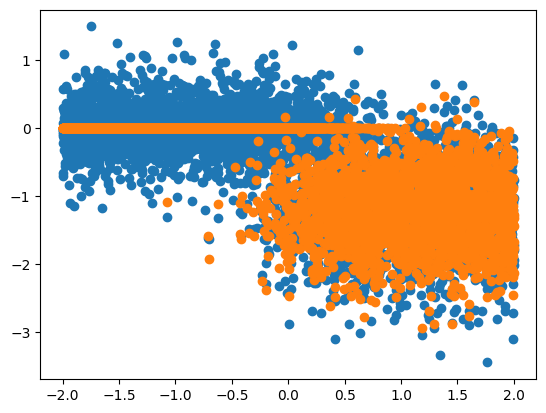

In [53]:

plt.scatter(x,betahat)
 
plt.scatter(x,y)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MDN model
class MDN(nn.Module):
    def __init__(self, input_dim):
        super(MDN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output: logit for pi_2
        )
        self.mu_1 = 0.0  # Fixed mean for component 1
        self.sigma_1_sq = 0.0  # Fixed variance for component 1
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Learnable mean for component 2

    def forward(self, x):
        logit_pi2 = self.fc(x).squeeze()
        pi_2 = torch.sigmoid(logit_pi2)
        pi_1 = 1 - pi_2
        return pi_1, pi_2, self.mu_2


# Loss function: Negative Log Likelihood
def mdn_loss(pi_1, pi_2, mu_2, sigma_2_sq, targets, sd_noise):
    mu_1 = torch.tensor(0.0)
    sigma_1_sq_total = sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets - mu_1) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    mixture_pdf = pi_1 * p1 + pi_2 * p2
    return -torch.mean(torch.log(mixture_pdf + 1e-8))


# Compute responsibilities (gamma values) for component 2
def compute_responsibilities(pi_1, pi_2,   mu_2, sigma_2_sq, targets, sd_noise):
    sigma_1_sq_total =0 + sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets ) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    return (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2)
  
# Perform the M-step to update sigma_2^2
def m_step_sigma2(gamma_2, mu_2, targets, sd_noise):
    residuals_sq = (targets - mu_2) ** 2
    sigma_0_sq = sd_noise**2
    numerator = torch.sum(( gamma_2 )* (residuals_sq - sigma_0_sq))
    denominator = torch.sum(( gamma_2 ))
    return torch.clamp(numerator / denominator, min=1e-6)


# Generate training data
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(betahat, dtype=torch.float32)
obs_sd_noise = torch.tensor(sebetahat, dtype=torch.float32)

# Initialize model and optimizer
model = MDN(input_dim=1)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)

# Training loop
n_epochs = 100
sigma_2_sqe = torch.tensor(1, requires_grad=False)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    pi_1, pi_2, mu_2e = model(x_tensor)

    gamma_2 = compute_responsibilities(
        pi_1=pi_1, pi_2=pi_2,
       
        mu_2=mu_2e, 
        sigma_2_sq=sigma_2_sqe,
        targets=y_tensor,
        sd_noise=obs_sd_noise
    ) 
    with torch.no_grad():
        sigma_2_sqe = m_step_sigma2( gamma_2, mu_2e, y_tensor, obs_sd_noise)

    loss = mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, y_tensor, obs_sd_noise)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Sigma_2^2: {sigma_2_sqe.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    pi_1, pi_2, mu_2e = model(x_tensor)


Epoch 0, Loss: 1.2908083200454712, Sigma_2^2: 1.4789414405822754


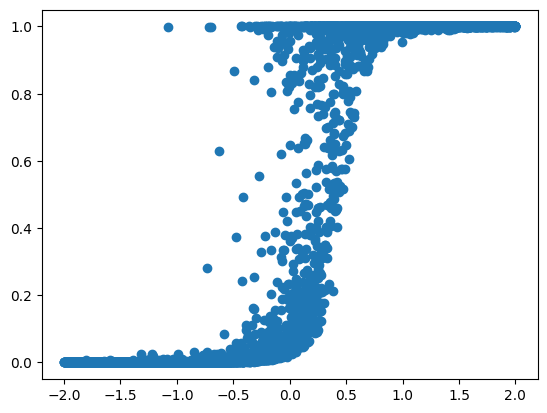

In [55]:
plt.scatter(x,gamma_2.detach().numpy() )

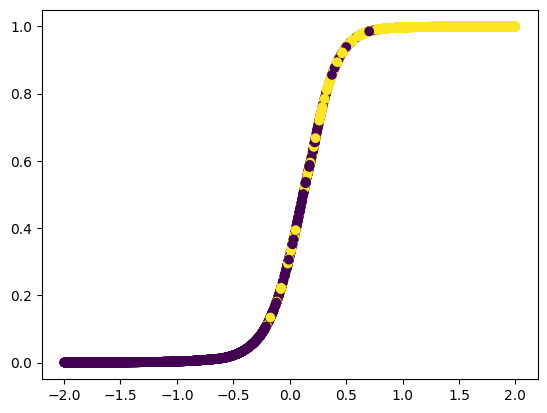

In [56]:
plt.scatter(x,pi_2.detach().numpy(), c=c )

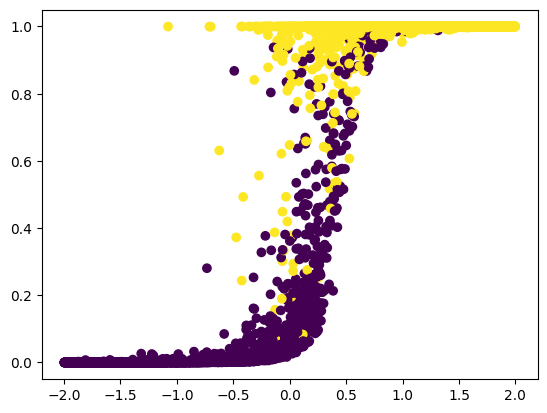

In [57]:
plt.scatter(x,gamma_2.detach().numpy(), c=c )

In [58]:
gamma_2.detach().numpy() 

array([2.2803748e-02, 7.9560202e-01, 1.0000000e+00, ..., 9.9438626e-01,
       4.0638410e-05, 8.6095434e-04], shape=(5000,), dtype=float32)

In [59]:
residuals_sq = (y_tensor - mu_2e) ** 2
sigma_0_sq = obs_sd_noise**2
numerator = np.sum((  gamma_2.detach().numpy()  )* (residuals_sq.detach().numpy()  - sigma_0_sq.detach().numpy() ))
print(numerator)
denominator = torch.sum((  gamma_2 ))
print(denominator)

788.69836
tensor(2455.9829, grad_fn=<SumBackward0>)


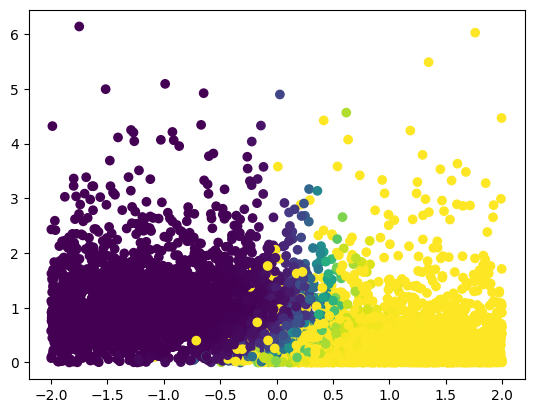

In [60]:
plt.scatter(x, residuals_sq .detach().numpy(
    
),c=gamma_2.detach().numpy() )

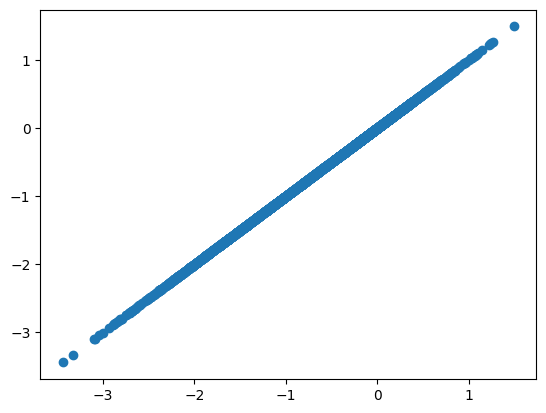

In [61]:
plt.scatter(y_tensor.detach(). numpy(), betahat)

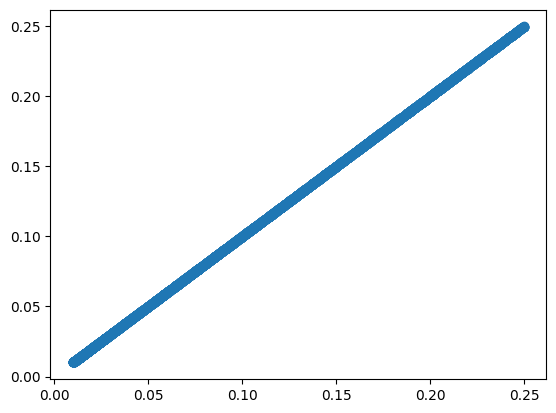

In [62]:
plt.scatter(sigma_0_sq.detach().numpy(), sebetahat**2)

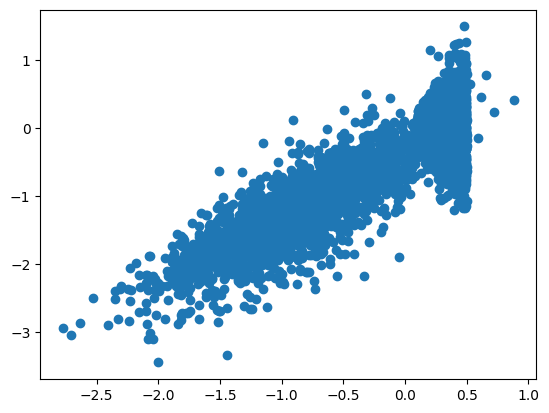

In [63]:
plt.scatter(y+sebetahat,betahat)

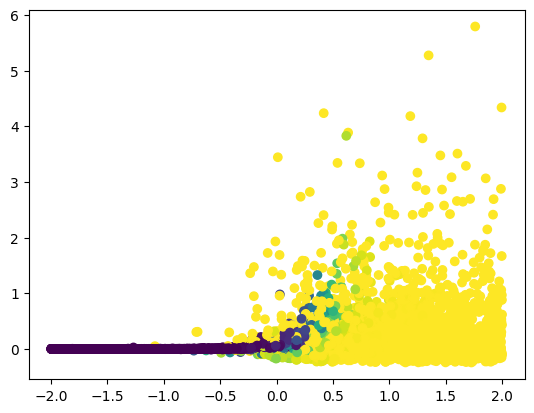

In [64]:
plt.scatter(x,(  gamma_2.detach().numpy() )* (residuals_sq.detach().numpy()) - gamma_2.detach().numpy() *(sigma_0_sq.detach().numpy()),
c=gamma_2.detach().numpy() )

In [65]:
tt= (betahat-mu_2)**2

print(sum(( gamma_2.detach().numpy()* (tt))))
print(sum(gamma_2.detach().numpy()* (sebetahat**2)))
sum(gamma_2.detach().numpy())

973.4952634339054
254.58222991161168


np.float32(2455.9758)

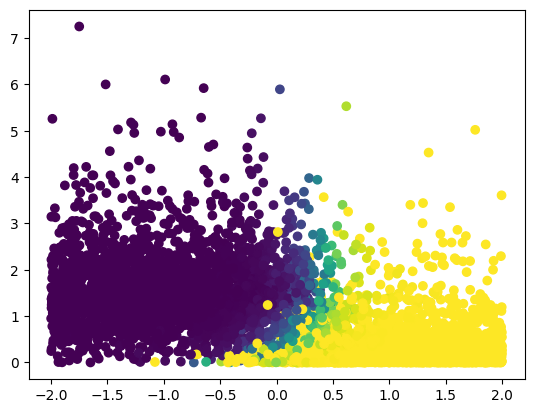

In [66]:
plt.scatter(x,tt,c=gamma_2.detach().numpy() )


In [67]:
numerator/denominator

tensor(0.3211, grad_fn=<MulBackward0>)

In [68]:
sigma_2_sq

0.5

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

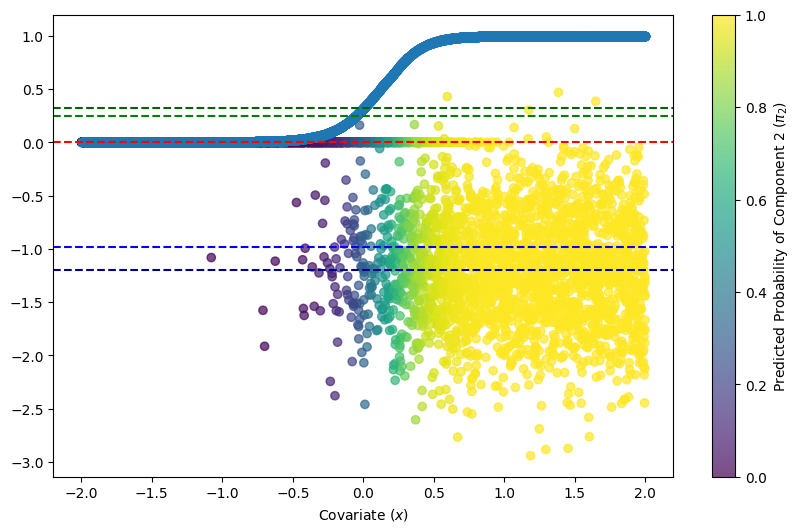

In [69]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x, pi_2,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(mu_2e.detach().numpy(), color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq   **2 , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( sigma_2_sqe.detach().numpy(), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


In [70]:
residuals_sq = (y_tensor - mu_2e) ** 2
print(torch.sum(residuals_sq))
sigma_0_sq = obs_sd_noise**2
print(torch.sum(sigma_0_sq))
print(torch.sum (residuals_sq - sigma_0_sq))
print(torch.sum ((1-gamma_2 )*(residuals_sq - sigma_0_sq)))


numerator = torch.sum((1-gamma_2 )* (residuals_sq - sigma_0_sq))
denominator = torch.sum((1-gamma_2 ))
print(numerator/denominator)

tensor(3835.7041, grad_fn=<SumBackward0>)
tensor(519.7488)
tensor(3315.9553, grad_fn=<SumBackward0>)
tensor(2527.2568, grad_fn=<SumBackward0>)
tensor(0.9934, grad_fn=<DivBackward0>)


(array([2355.,   95.,   50.,   39.,   34.,   26.,   27.,   29.,   56.,
        2289.]),
 array([4.12158170e-06, 1.00003712e-01, 2.00003311e-01, 3.00002873e-01,
        4.00002480e-01, 5.00002086e-01, 6.00001633e-01, 7.00001240e-01,
        8.00000846e-01, 9.00000453e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

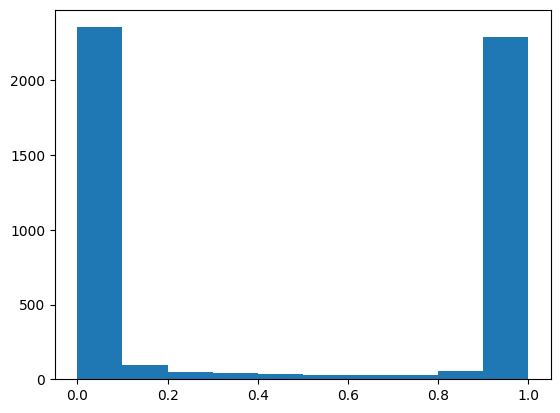

In [71]:
plt.hist(gamma_2.detach().numpy() )

In [72]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from covaraite_moderated_generalized_binary import *